### *FIRST STEP* This script is to import raw eeg files and plot eeg activity via topoplots (exclusion already asessed)
## Last Modified : 5/28/24

In [21]:
# load libs
import numpy as np 
import scipy 
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
import mne
from mne.viz import plot_topomap
from mne.io import RawArray
import numpy.matlib
sns.set_theme() # set the plotting atmosphere
rbow = sns.color_palette('husl',8)

In [3]:
NumHarms = 4
prebins = 1
NumBins = 6 # 6 contrasts
allbins = prebins+NumBins # 6 contrasts + prelude bin (7)
NumChans = 128
NumHemis = 2 # hemifield data = NumHarms*NumHemis # 8 : 2f1 4f1 6f1 8f1 2f2 4f2 6f2 8f2
NumFriters = NumHarms*NumHemis
co = 0 # condition out of 6 
### row count to determine if 1f1 data exists
ExpectedRows = (8*allbins)* 2 # 112 
BadRows = (9*allbins)*2 # 126
h = np.arange(0,NumFriters,1)
# set freq index list for 2f1 - 8f2 data
hIters = np.sort(np.tile(h,allbins))
chanInd = np.arange(1,NumChans,1) # channel index ...

In [4]:
# montage info 
montageIn = mne.channels.make_standard_montage("GSN-HydroCel-128")
info = mne.create_info(ch_names=montageIn.ch_names, sfreq=1, ch_types="eeg")
info.set_montage(montageIn)
print(montageIn)
# contrast labels
cll=['1%', '3%', '5%', '16%', '40%', '100%']
# occipital electrode placement locs
elec_Arc1_outer = [68,64,58,51,47,42,37,31,    80,87,93,98,97,96,95,94]
elec_Arc2 = [73,69,65,59,52,53,54,  55,  79,86,92,91,90,89,88]
elec_Arc3 = [74,70,66,60,61,  78,85,84,83,82,  81]
elec_Arc4_inner = [71,67,62,77,76,75,    72]
AllAnalysisChans = np.concatenate([elec_Arc1_outer,elec_Arc2,elec_Arc3,elec_Arc4_inner])
AnalysisChans = np.unique(AllAnalysisChans) - 1
VisChans = np.sort(AnalysisChans)
print(f'Channels to be visualized: {VisChans}')
ocm = np.zeros_like((np.arange(0,NumChans,1)))
ocm[VisChans] = True # set good chans to true
#ocm_chans = ocm.astype(bool)

# function to plot topos
def init_TopoTemplate(title_In):
    """Prep topo plot fig and axes"""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    axes[0].axis('off')
    axes[1].axis('off')
    axes[0].gridspec_kw=dict(height_ratios=[3])
    axes[1].gridspec_kw=dict(height_ratios=[3])
    plt.tight_layout()
    plt.suptitle(f'{title_In}', fontsize = 20)
    return fig, axes

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 128 channels>
Channels to be visualized: [30 36 41 46 50 51 52 53 54 57 58 59 60 61 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97]


### Import all files that will be sorted and exported into another .mat file

In [5]:
# Main Directory of processed file from MatLab
# MainDir = 'C:\\plimon\\LTP_analysis\\eegMatFiles\\MAT' # set dir (old dir)
MainDir = 'C:\\plimon\\LTP_analysis\\Fx_LTP_MatFiles\\F1_data\\Mat' # set dir (old dir)
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Number of Files on hand: {int(len(d))}')
Fnames = np.sort(d) # get all subjects label names 

Number of Files on hand: 55


In [6]:
SignalData  = {} # ave average data 
#RealnImaginaryData = {} # save real and imaginary data 
for suIn in range(len(d)):#range(10):# og d 
    SignalData[suIn]  = {}
    #RealnImaginaryData[0] = {}
### import file via path 
    FileN = Fnames[suIn] # import from sorted subj expt name list                       
    file_path = os.path.join(MainDir, FileN) # join paths and prep 2 load
    mat_data = scipy.io.loadmat(file_path) # import data file

### extract signal data from file and dims
    MainData = mat_data['signalData'][co][0]
    SortDataIn = np.array(MainData)
    [NumRows, NumChans, NumTrials] = SortDataIn.shape # get dims of data to use later ..
    real_imag_bound = int((NumRows/2)) # real and imaginary freq values ...
    # prepost_bound = int(NumTrials/2)
    # tInds = np.arange(0,NumTrials,prepost_bound)# trial inds

### reshape real and imaginary values and remove 0's with nan's
    dIn = SortDataIn.reshape(real_imag_bound,2,NumChans,NumTrials,order='A')
    # RealnImaginaryData[suIn]= dIn    
    dIn[dIn==0]=np.nan
    #print(dIn.shape)
    RowCount = int(dIn.shape[0])
    if RowCount == int(ExpectedRows/2): # if data dont have extra f1 data
        print(f'data is expected shape {dIn.shape}')
        data = dIn
    else:
        #print(f'data contains f1 info') # data has extra f1 info - rmv
        data = dIn[allbins:,:,:] # remove 0-7 rows
        print(f'1f1 data removed, new shape {data.shape}')
    # RealnImaginaryData[suIn] = data

    xF_Bins = {}
    for hi in range(8):
        tempIn =data[hIters == hi]
        tempOut = tempIn[1:,:,:,:]
        xF_Bins[hi] = tempOut

    SignalData[suIn]  = xF_Bins

1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data removed, new shape (56, 2, 128, 78)
1f1 data r

In [7]:
print(f'Total Files Imported {int(len(SignalData.keys()))}')

Total Files Imported 55


In [8]:
allData = {} # store eeg channel activity 
complexValData = {} # store real and imaginary numbers

for allFiles in range(len(d)): # len(d)
    allData[allFiles] = {}  # new subkeys per sub key
    complexValData[allFiles] = {} # new subkeys per sub key
    sdIn = SignalData[allFiles] # import 1 subjects data for all 1f1-8f2

    for fi in range(NumFriters):
        avg = np.zeros((2,6,128)) # empy array to fill for each 2f1-8f2
        Complex_avgs  = np.zeros((2,6,2,128)) # [pre post x bins x complex (real/imag) x chans]
        sdkIn = sdIn[fi] # import one data array for 2-8 F1-F2 [6x2x128x78]
        #print(sdkIn.shape)
        nt = np.shape(sdkIn)[3] # get trial # completed
        prepost_bound = int(nt/2) # index to split data 
        tInds = np.arange(0,nt,prepost_bound)# trial inds

        for ppb in range(2): # iterate for pre post data matricies
            st = tInds[ppb] # start index 
            ed = st+prepost_bound # end index
            minimat = sdkIn[:,:,:,st:ed] # import pre or post chunk of data [binxrealimagxchansxtrials]
            #print(minimat.shape) # 6 x 2 x 128 x 39
                ############ get average channel activity pre / post induction 
            for b in range(NumBins): # per bin
                for ch in range(NumChans): # per channel
                    reN = np.nanmean(minimat[b,0,ch,:]) # real vales 
                    imagN = np.nanmean(minimat[b,1,ch,:]) # imaginary values
                    h = np.hypot(reN,imagN) # hypotenuse of real and imaginary
                    avg[ppb,b,ch] = h # 2 x 6 x 128
            allData[allFiles][fi] = avg
        ############# get avg real and imaginary values for all trials for one bin,one channel
            for bi in range(NumBins):
                sig = minimat[bi,:,:,:] # 2 x 128 x 39 = real/imaginary x channels x trials
                for clex in range(2):
                    cmlx_dim  = sig[clex,:,:] # real or imaginary  = [128x 39]
                    #cmplx_avg = np.nanmean(cmlx_dim,axis = 1)
                    Complex_avgs[ppb,bi,clex,:] = np.nanmean(cmlx_dim,axis = 1)
            complexValData[allFiles][fi] = Complex_avgs

C:\Users\plimon\AppData\Local\Temp\ipykernel_31580\3671881527.py:26: RuntimeWarning: Mean of empty slice
  reN = np.nanmean(minimat[b,0,ch,:]) # real vales
C:\Users\plimon\AppData\Local\Temp\ipykernel_31580\3671881527.py:27: RuntimeWarning: Mean of empty slice
  imagN = np.nanmean(minimat[b,1,ch,:]) # imaginary values
C:\Users\plimon\AppData\Local\Temp\ipykernel_31580\3671881527.py:37: RuntimeWarning: Mean of empty slice
  Complex_avgs[ppb,bi,clex,:] = np.nanmean(cmlx_dim,axis = 1)


#### Rmv hashtag to plot channel activity for 2f1 and 2f2 

In [10]:
# for j in range(10):
#     f1_pp = allData[j][0]
#     f2_pp = allData[j][4]

#     plt.plot(f1_pp[0,5,:], color = 'black', label = 'pre F1')
#     plt.plot(f1_pp[1,5,:],color = 'blue', label = 'post F1')
#     plt.plot(f2_pp[0,5,:], color = 'black', alpha = 0.5, label = 'pre F2')
#     plt.plot(f2_pp[1,5,:],color = 'red', label = 'post F2')
#     plt.title(f'F1/2 avg channel actvity, {Fnames[j]}')
#     plt.legend()
#     plt.show()

In [9]:
# for stp in range(len(d)):
#     fxs = [allData[stp][0], allData[stp][4]] # freq set xf1 xf2
#     fxl = ['F1','F2']

#     for i in range(1): # import f1 and f2 data
#         t = fxs[i]
#         #print(t.shape)
#         for contrast in range(1): # NumBins
#             tIn_pre = np.array(t[0,contrast+5,:])
#             tIn_post = np.array(t[1,contrast+5,:])

#             fig, axes = init_TopoTemplate(f'{Fnames[stp]}, {fxl[i]}, {cll[contrast+5]}')

#             im,_ = plot_topomap(tIn_pre,info,mask = ocm,axes = axes[0],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =3,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
#             im,_ = plot_topomap(tIn_post,info,mask = ocm,axes = axes[1],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =3,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')

#             divider = make_axes_locatable(axes[1])
#             cax = divider.append_axes('right', size='5%', pad=0.1)
#             cbar = plt.colorbar(im, cax=cax)

# plot single subject data to confirm

#### Bad Subjs: [2661,2669]

nl-2658_attnL_20231013_1639_RLS.mat


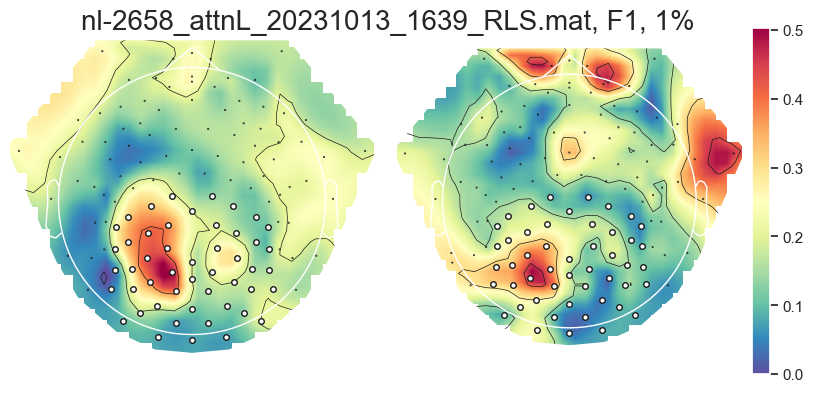

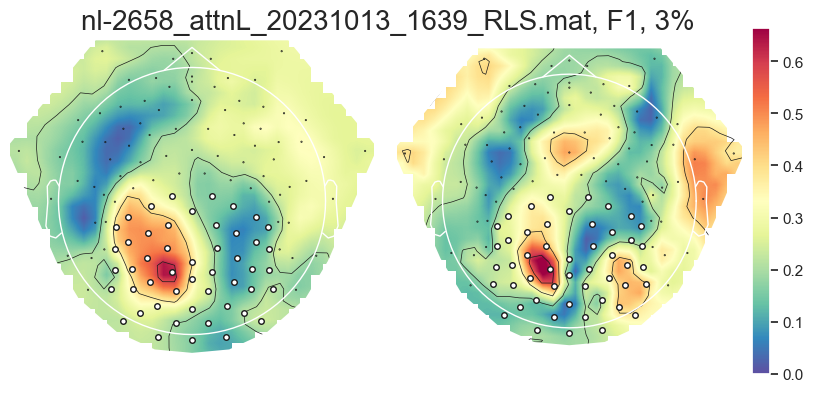

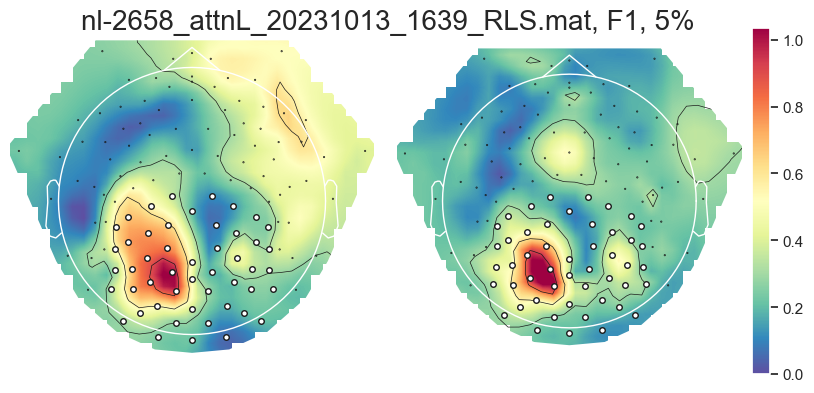

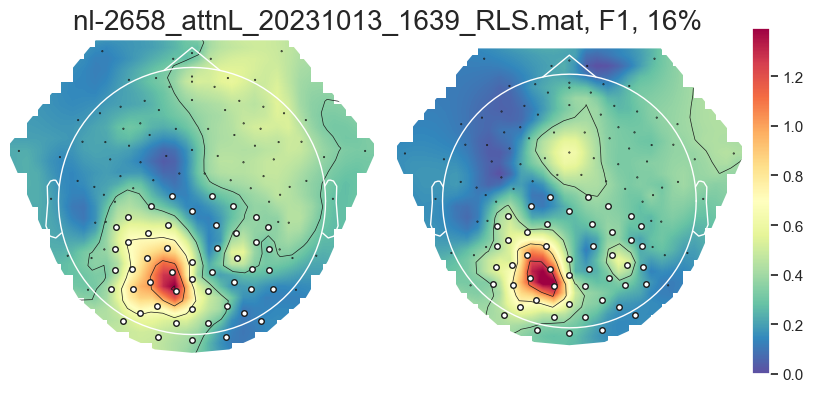

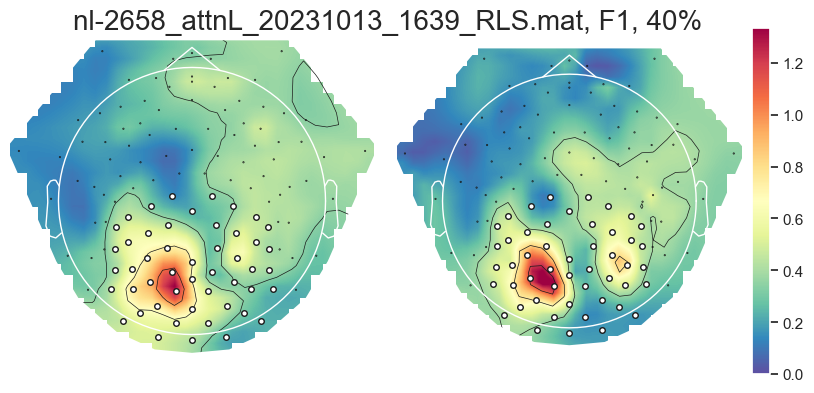

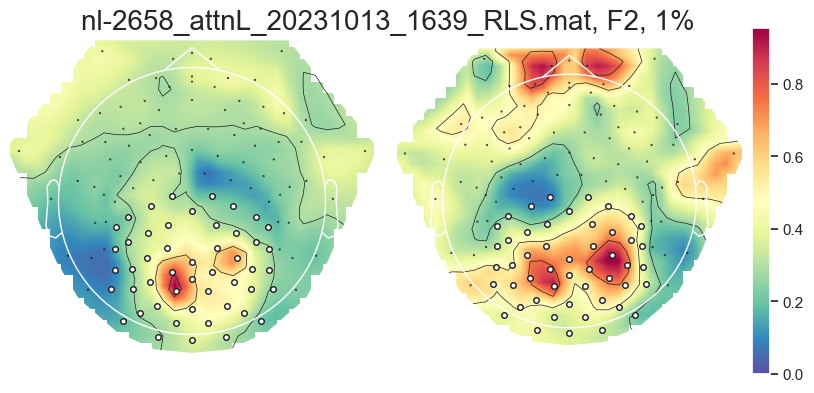

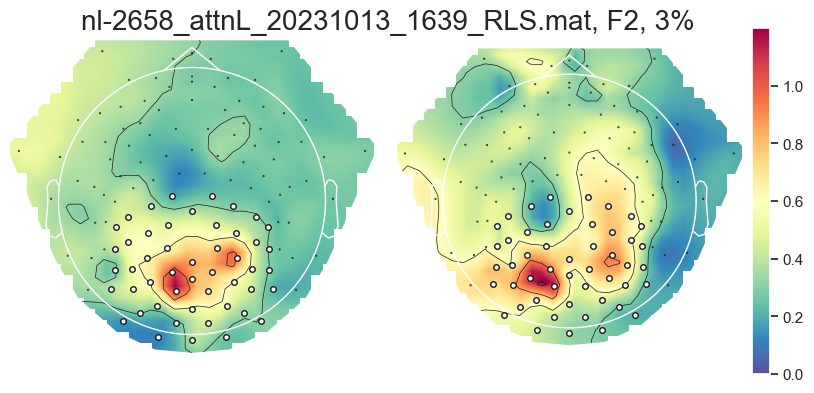

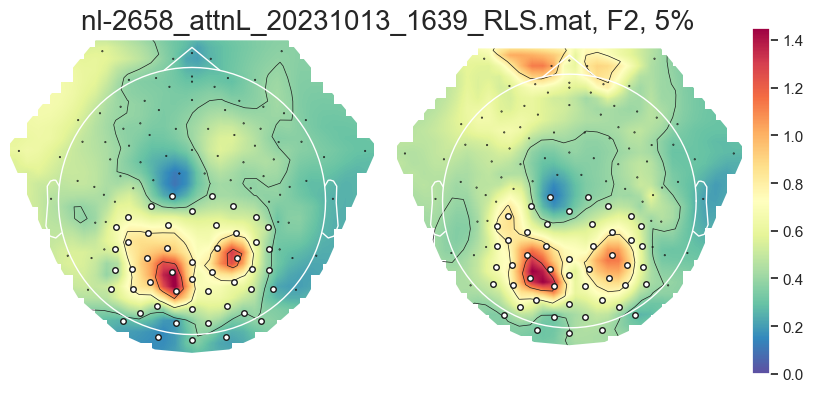

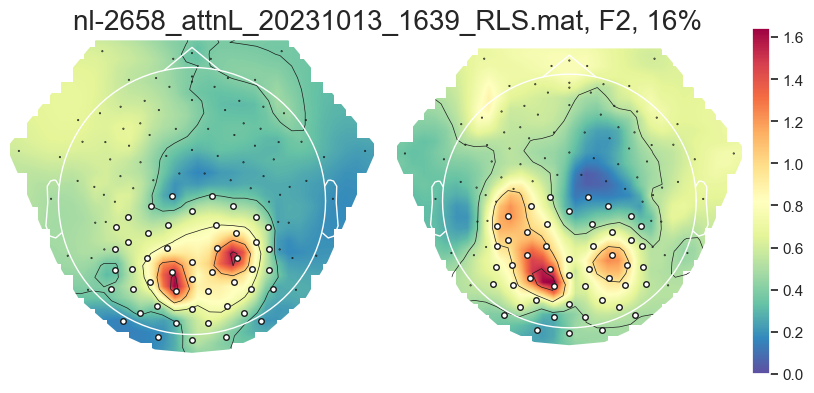

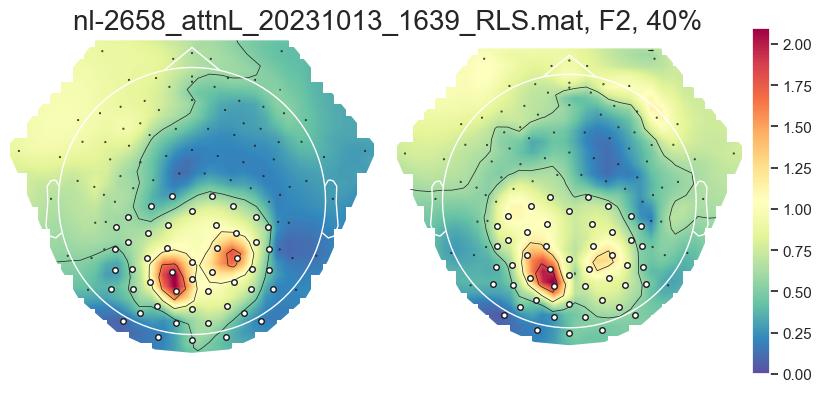

In [10]:
dubSub = 10
print(Fnames[dubSub])

fxs = [allData[dubSub][0], allData[dubSub][4]] # freq set xf1 xf2
fxl = ['F1','F2']

for i in range(2): # import f1 and f2 data
    t = fxs[i]
    #print(t.shape)
    for contrast in range(5): # NumBins
        tIn_pre = np.array(t[0,contrast,:])
        tIn_post = np.array(t[1,contrast,:])

        fig, axes = init_TopoTemplate(f'{Fnames[dubSub]}, {fxl[i]}, {cll[contrast]}')

        im,_ = plot_topomap(tIn_pre,info,mask = ocm,axes = axes[0],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =3,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
        im,_ = plot_topomap(tIn_post,info,mask = ocm,axes = axes[1],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =3,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')

        divider = make_axes_locatable(axes[1])
        cax = divider.append_axes('right', size='5%', pad=0.1)
        cbar = plt.colorbar(im, cax=cax)

#### bad subj files names here:
# 2653_attnR_20231013_0932_RLS
# 2655_attnL_20231009_1303_RLS
# 2657_attnR_20231020_1201_RLS
# 2661_attnL_20231018_1322_RLS
# 2661_attnR_20231017_1358_RLS
# 2669_attnR_20231023_1241_RLS
# 2728-attnL_20240305_1534_RLS
# 2733-attnL_20240312_1701_RLS
# 
# Dubious ...
# 2655_attnR_20231016_0948_RLS
# 2671_attnL_20231024_1107_R LS

In [11]:
print(int(len(complexValData.keys())))

56


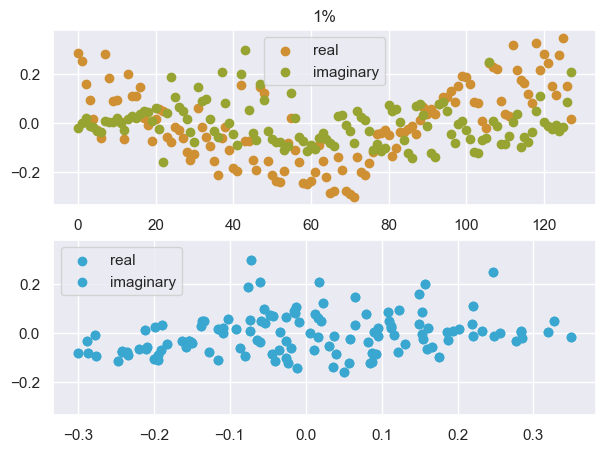

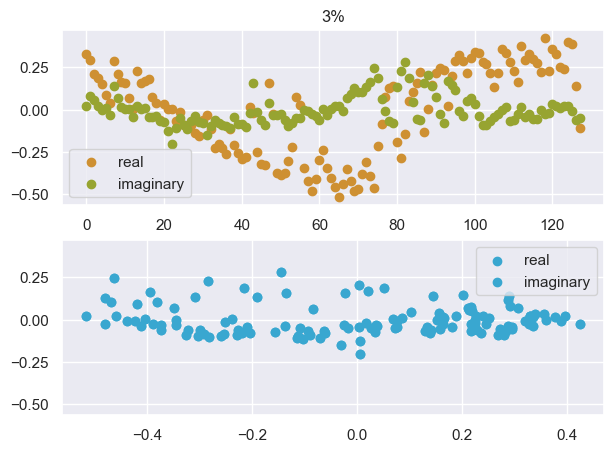

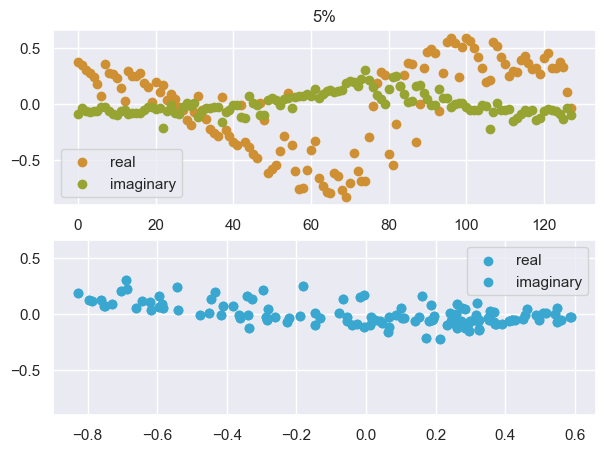

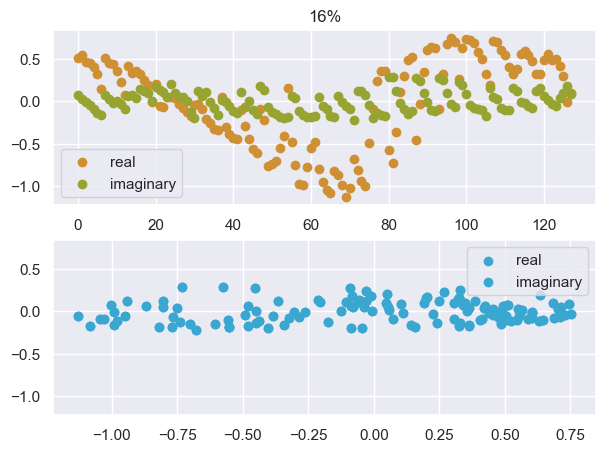

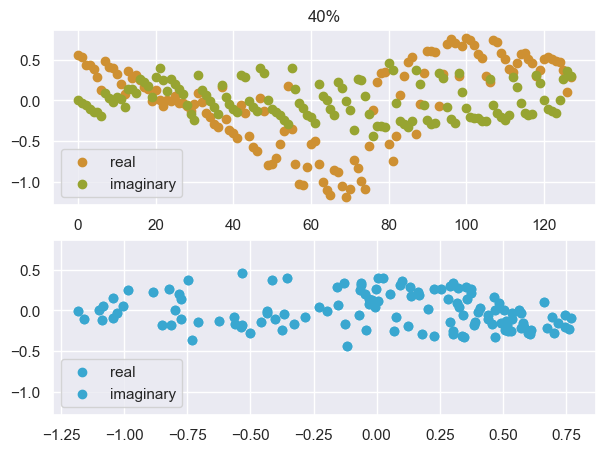

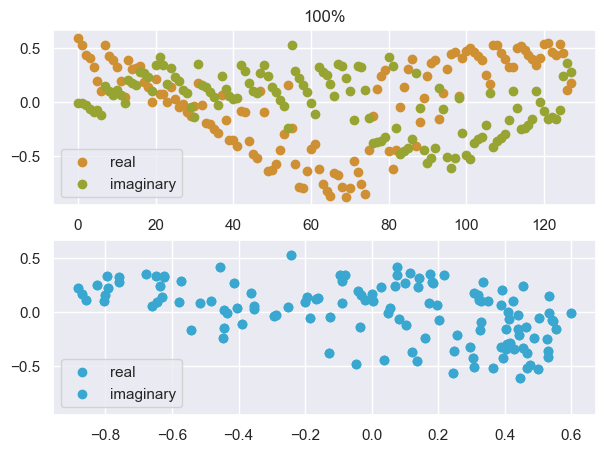

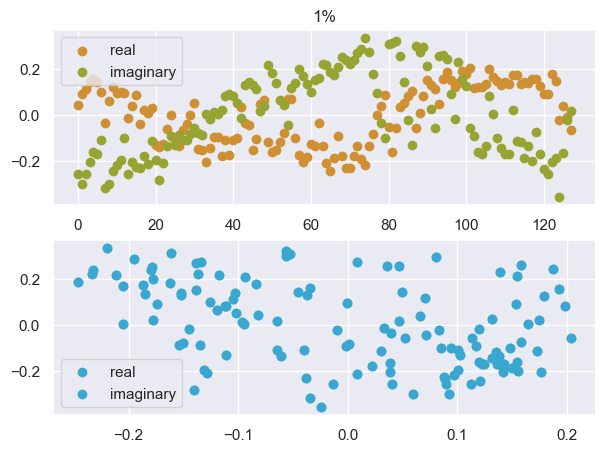

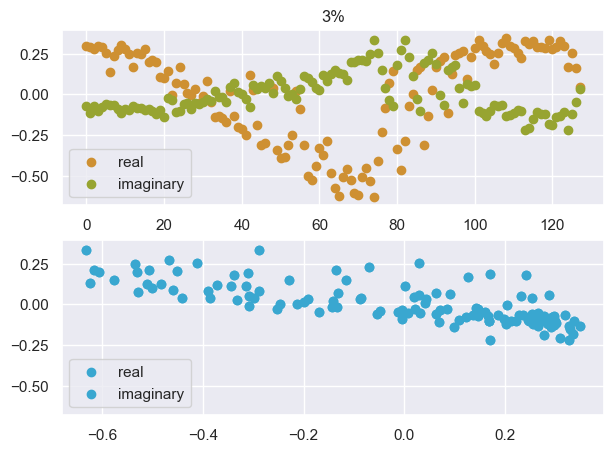

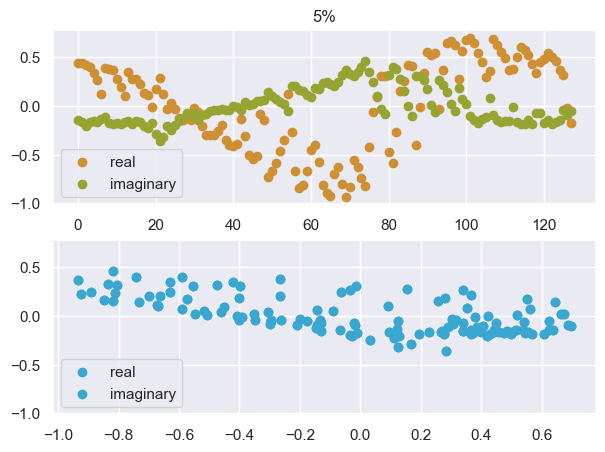

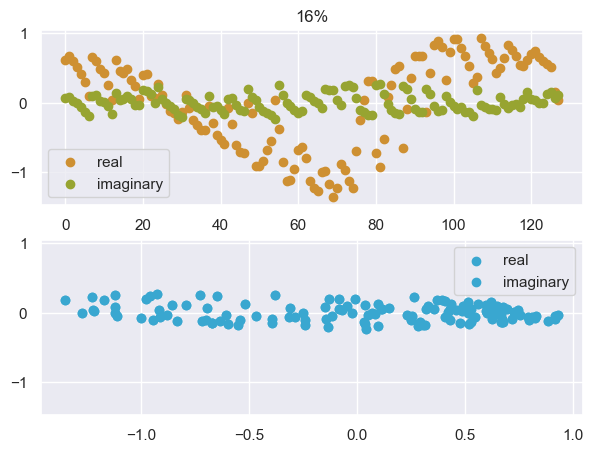

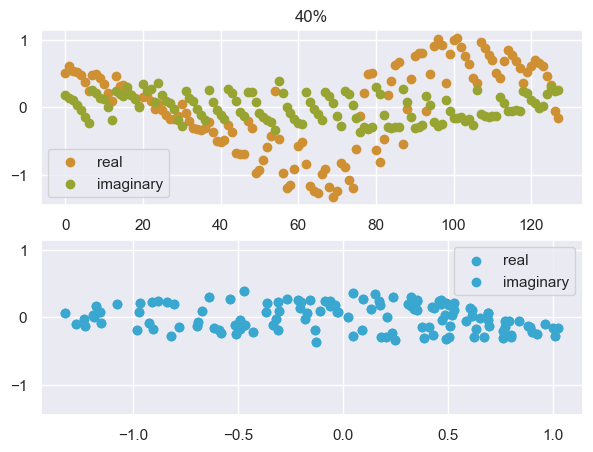

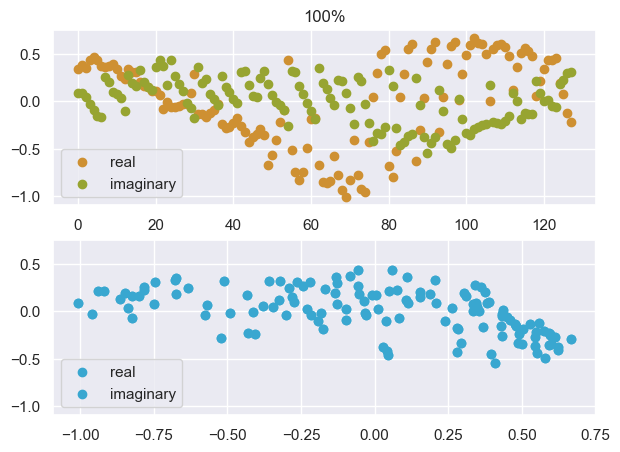

In [12]:
cvd = complexValData[30][0] #  2 x 6x 2 x 128
cxl = ['real','imaginary']

for pp in range(2):
    pd = cvd[pp,:,:,:]
    for bi in range(NumBins):
        fig,axs = plt.subplots(2,1,figsize = (7,5),sharey = True)
        lo_c = pd[bi,:,:] # [2 x 128]
        for ri in range(2):
            axs[0].scatter(np.arange(0,NumChans,1), lo_c[ri,:], label = f'{cxl[ri]}', color = rbow[ri+1])
            axs[1].scatter( lo_c[0,:], lo_c[1,:], label = f'{cxl[ri]}', color = rbow[5])
            axs[0].legend()
            axs[1].legend()
            axs[0].set_title(f'{cll[bi]}')
# [pre post x bins x complex (real/imag) x chans]

In [13]:
# fig,axs = plt.subplots(2,1,figsize = (10,6),sharey = True)
# for ppb in range(2):
#     for s in range(6):
#         axs[ppb].scatter(np.arange(0,NumChans,1),avg[ppb,s,:],label = f'{cll[s]}', alpha = 0.7)
#         axs[ppb].plot(avg[ppb,s,:])
#         axs[ppb].legend()
# plt.suptitle(f'Pre Post Channel activity per bin')

In [14]:
FileNamesIndicies = np.array(d) # make list into array 
FileName = [FileNamesIndicies.replace('_','-') for FileNamesIndicies in FileNamesIndicies] # uniform fnames to make bools for attnl and attnR 

In [15]:
DataOut = {}

DataOut['RealImaginaryData_sIns'] = complexValData
DataOut['EEGData'] = allData
DataOut['SubIDs'] = FileName

In [16]:
SaveDataDir = 'C:\\plimon\\LTP_analysis\\eegMatFiles\\AllMat'
print(os.path.exists(SaveDataDir)) # does pth exist :p

dnt = datetime.now() # add date and time bc im wreckless when saving ..
fdnt = dnt.strftime("%Y%m%d_%H%M%S") # set the above as a string ...
FileOutName = 'Clean_Procc_Data_pnlApproved'
FileN = f'{FileOutName}_{fdnt}.pkl' 
NewFileNPath = os.path.join(SaveDataDir,FileN)
print('Full New File Dir: ', NewFileNPath)

saveFile = 'y'
if saveFile == 'y':
 with open(NewFileNPath, 'wb') as file:
    pkl.dump(DataOut, file, protocol=pkl.HIGHEST_PROTOCOL)
    print('MAT Data For All Subjs Saved! :))')
else:
    print('Did Not Save File! Change file name before switching to y!')

True
Full New File Dir:  C:\plimon\LTP_analysis\eegMatFiles\AllMat\Clean_Procc_Data_pnlApproved_20240528_143903.pkl
MAT Data For All Subjs Saved! :))
